## 0. Preparation
In this first assignment we will prepare the dataset for use:<br />
a. Download the Auto.csv dataset from ISL (https://www.statlearning.com/resources-python)<br />
b. Load the dataset<br />
c. Drop all variables except the (potential) predictors ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year'] and the target variable 'mpg'<br />
d. Split the dataset into a training set (80%) and a validation set (20%). It is probably a good idea to shuffle the dataset prior to this<br />
e. Replace missing values (coded as '?') in the both datasets with the mean of the given variable in the training set<br />
f. Standardize the predictors in the training set<br />
g. Standardize the predictors in validation set based on the means and standard deviations from the training set<br />

In [107]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler


np.random.seed(42)

# b)
df = pd.read_csv('/Users/esten/Downloads/Auto.csv')
print(f'Loaded {len(df)} samples')

# c)
predictors = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year']
target = 'mpg'
df = df[predictors + [target]]
df = df.replace('?', None)
df = df.astype(float)

# d)
df = df.sample(frac=1.)
train = df.iloc[:int(len(df) * 0.8)].copy()
validation = df.iloc[int(len(df) * 0.8):].copy()
print(f'Using {len(train)} samples for training')
print(f'Using {len(validation)} samples for validation')

# e)
for column in train.columns:
    mean_value = np.nanmean(train[column].astype(float).values)
    train.loc[np.isnan(train[column]), column] = mean_value
    validation.loc[np.isnan(validation[column]), column] = mean_value

# f)
scaler = StandardScaler()
train[predictors].values[:] = scaler.fit_transform(train[predictors])
validation[predictors].values[:] = scaler.transform(validation[predictors])

Loaded 397 samples
Using 317 samples for training
Using 80 samples for validation


## 1. Manual variable selection
In this assignment all models should be unregularized linear regression models trying to predict mpg as a function of various subset of predictors. When not mentioned explicitly, the best model is the one achieveing the lowest mean squared error (MSE) in the validation set.<br />
a. Find the optimal set of predictors of size [6, 5, 4, 3, 2, 1] using backwards stepwise selection. Print out each set.<br />
b. Based on the models you have already trained, plot both training and test MSE as a function of the number of predictors<br />
c. Using the values plotted in b), what is the best model based on training MSE? What about test MSE? If they are different, reflect briefly on why. If not, could this happen? Why/why not?<br />
d. Plot predictions against actual values and print MSE for the test set using the best model.

In [128]:
from copy import copy
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from typing import List


def fit_and_evaluate(model: LinearRegression, train: pd.DataFrame, validation: pd.DataFrame, 
                     predictors: List[str], target: str):
    train_X = train[predictors].values
    train_y = train[target].values
    validation_X = validation[predictors].values
    validation_y = validation[target].values
    
    model.fit(train_X, train_y)
    train_predictions = model.predict(train_X)
    validation_predictions = model.predict(validation_X)
    
    return mse(train_y, train_predictions), \
           mse(validation_y, validation_predictions), \
           validation_predictions

remaining_predictors = copy(predictors)
train_error, validation_error, predictions = fit_and_evaluate(LinearRegression(),
                                                              train, 
                                                              validation, 
                                                              predictors=remaining_predictors, 
                                                              target=target)
overall_results = [{
    'removed': None,
    'predictors': remaining_predictors.copy(),
    'train_error': train_error,
    'validation_error': validation_error,
    'predictions': predictions
}]

while len(remaining_predictors) > 1:
    results = {}
    
    for predictor in remaining_predictors:
        subset = [p for p in remaining_predictors if p != predictor]
        train_error, validation_error, predictions = fit_and_evaluate(LinearRegression(),
                                                                      train, 
                                                                      validation, 
                                                                      predictors=subset, 
                                                                      target=target)
        results[predictor] = {
            'train_error': train_error,
            'validation_error': validation_error,
            'predictions': predictions
        }

    worst_predictor = sorted(results.keys(), key=lambda x: results[x]['validation_error'])[0]
    remaining_predictors = [p for p in remaining_predictors if p != worst_predictor]
    print(remaining_predictors)
    
    overall_results.append({
        'removed': worst_predictor,
        'predictors': remaining_predictors.copy(),
        'train_error': results[worst_predictor]['train_error'],
        'validation_error': results[worst_predictor]['validation_error'],
        'predictions': results[worst_predictor]['predictions']
    })



['cylinders', 'displacement', 'weight', 'acceleration', 'year']
['cylinders', 'weight', 'acceleration', 'year']
['weight', 'acceleration', 'year']
['weight', 'year']
['weight']


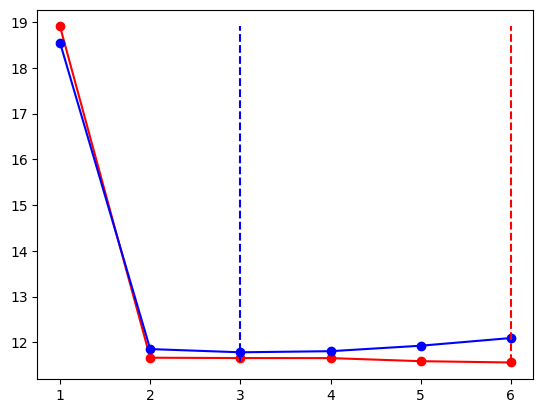

In [129]:
import matplotlib.pyplot as plt

num_predictors = [len(entry['predictors']) for entry in overall_results]
train_errors = [entry['train_error'] for entry in overall_results]
validation_errors = [entry['validation_error'] for entry in overall_results]
min_train_error = np.argmin(train_errors)
min_validation_error = np.argmin(validation_errors)

ymin = min([np.amin(train_errors), np.amin(validation_errors)])
ymax = max([np.amax(train_errors), np.amax(validation_errors)])

plt.plot(num_predictors, train_errors, 'ro-')
plt.plot(num_predictors, validation_errors, 'bo-')

plt.plot([num_predictors[min_train_error], num_predictors[min_train_error]], [ymin, ymax], 'r--')
plt.plot([num_predictors[min_validation_error], num_predictors[min_validation_error]], [ymin, ymax], 'b--')

plt.show()

MSE: 11.782341931922975


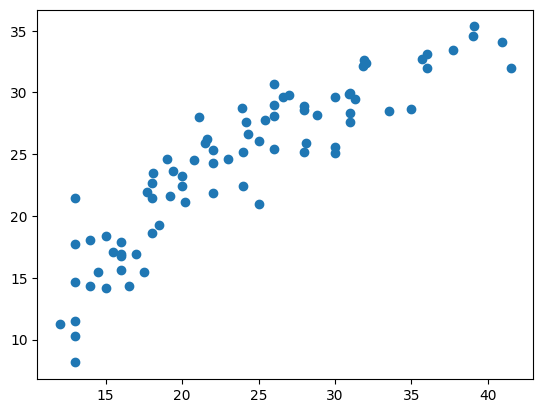

In [130]:
predictions = [entry['predictions'] for entry in overall_results]
print(f'MSE: {mse(validation[target].values, predictions[min_validation_error])}')

plt.scatter(validation[target].values, predictions[min_validation_error])
plt.show()

## 2. Regularization and automatic variable selection<br />
In this assignment you will fit regularized LASSO models to investigate how the value of the regularization parameter affects predictive performance and degree of overfitting. You will also compare this approach with the manual approach from assignment 1.
a. Fit a range of LASSO models using all predictors, with lambdas = [0, 1, ..., 10]<br />
b. Plot the train and validation MSE as a function of the value of lambda<br />
c. Using the values plotted in b), what is the best model (defined by lambda) based on training MSE? What about test MSE? If they are different, reflect briefly on why. If not, reflect briefly on whether this could happen.<br />
d. Plot predictions against actual values and print MSE for the test set using the best model. Is the best LASSO model better or worse than the best model found using backward stepwise selection? Discuss briefly why/why not this can be the case.<br />
e. Print the names and coefficients of the predictors that are used by the LASSO model (e.g. not set to 0). How does this compare to the list you found using backwards stepwise selection?

/var/folders/ps/g7dr3f8x0vnbdn4gn57pntfh0000gn/T/ipykernel_43293/257098985.py:14: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(train_X, train_y)
/Users/esten/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/esten/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.832e+03, tolerance: 1.954e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instea

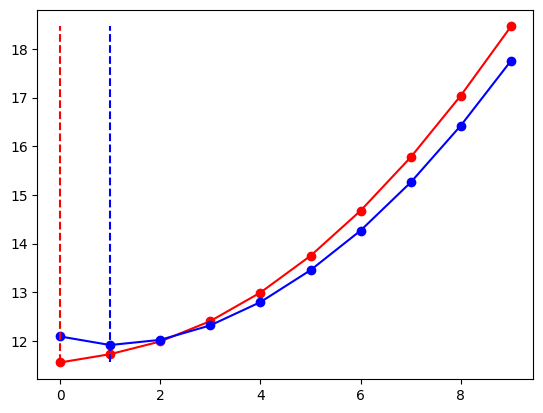

In [133]:
from sklearn.linear_model import Lasso


results = []
alphas = np.arange(0, 10, 1)

for alpha in alphas:
    model = Lasso(alpha=alpha)
    train_error, validation_error, _ = fit_and_evaluate(model,
                                                        train, 
                                                        validation, 
                                                        predictors=predictors, 
                                                        target=target)
    results.append({
        'train_error': train_error,
        'validation_error': validation_error,
        'model': model
    })
    

train_errors = [entry['train_error'] for entry in results]
validation_errors = [entry['validation_error'] for entry in results]
min_train_error = np.argmin(train_errors)
min_validation_error = np.argmin(validation_errors)

ymin = min([np.amin(train_errors), np.amin(validation_errors)])
ymax = max([np.amax(train_errors), np.amax(validation_errors)])

plt.plot(alphas, train_errors, 'ro-')
plt.plot(alphas, validation_errors, 'bo-')

plt.plot([alphas[min_train_error], alphas[min_train_error]], [ymin, ymax], 'r--')
plt.plot([alphas[min_validation_error], alphas[min_validation_error]], [ymin, ymax], 'b--')

plt.show()

80
80
MSE: 11.918106432120831


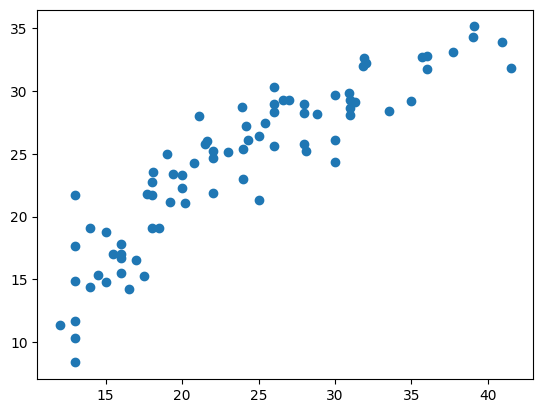

In [143]:
predictions = results[min_validation_error]['model'].predict(validation[predictors].values)
print(len(predictions))
print(len(validation[target].values))
print(f'MSE: {mse(validation[target].values, predictions)}')

plt.scatter(validation[target].values, predictions)
plt.show()

In [146]:
coefficients = list(zip(predictors, results[min_validation_error]['model'].coef_))
coefficients

[('cylinders', -0.0),
 ('displacement', 0.0017052884215495315),
 ('horsepower', -0.0),
 ('weight', -0.006824747248157405),
 ('acceleration', 0.0),
 ('year', 0.6922807797559918)]